In [1]:
# Load libraries

# # Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import matplotlib.patches as patches
import matplotlib as matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Analysis
import os
import numpy as np 
import xarray as xr
import datetime
from   datetime import date, timedelta
import pandas as pd 
#import regionmask
import pickle
import scipy.stats as stats
import glob
import Ngl
import Nio 
import metpy.calc as mpc
from metpy.units import units


In [2]:
import warnings
warnings.filterwarnings('ignore')


## Read in data

In [4]:
# Where the files are saved (locally):
dataDir_CLUBB = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/NoMoments-SrfFluxAvg_withCTSMmods/'
dataDir_CLASP = '/Users/mdfowler/Documents/Analysis/CLASP/SCAM_runs/UseCTSMmods_Irrig_SrfFluxAvg/'

# File naming conventions: 
startFile_CLUBB = 'FSCAM.T42_T42.arm97.clasp_useAndre_noMomentsWithCTSMmods-Irrig-SrfFluxAvg_startDay'
startFile_CLASP = 'FSCAM.T42_T42.arm97.clasp_useAndre_useCTSMmods-Irrig-SrfFluxAvg_startDay'

middleFile_CAM  = '.cam.h0.2015-'
middleFile_CLM  = '.clm2.h1.2015-'
endFile         = '-00000.nc'

# Month/day also factor into naming convention (since these are run for ~2 days and second day is used)
months    = np.ones(31)*6
months[0] = 5
days      = np.arange(0,28)
days[0]   = 31


In [12]:
# Now read in each daily file, and save the appropriate second day to an xr dataset: 

for iDay in range(26):
    
    # --------------------------------------------------------------
    # --------------------------------------------------------------
    # Datasets are run with irrigation ON and srf_flux_avg = 1 
    # --------------------------------------------------------------
    # --------------------------------------------------------------
    
    # Define full file names 
    if iDay==0:
        clubbFile    = dataDir_CLUBB+startFile_CLUBB+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile_CAM+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
        claspFile    = dataDir_CLASP+startFile_CLASP+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile_CAM+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+'-00172.nc'        
    else:
        clubbFile    = dataDir_CLUBB+startFile_CLUBB+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile_CAM+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile
        claspFile    = dataDir_CLASP+startFile_CLASP+'0'+str(months[iDay].astype(int))+str('%02i' % days[iDay])+middleFile_CAM+'0'+str(months[iDay].astype(int))+'-'+str('%02i' % days[iDay])+endFile

    # ---------------------------------------- 
    # Read in data CLUBB computed on its own
    # ----------------------------------------
    with xr.open_dataset(clubbFile, decode_times=True, engine='scipy') as clubb_DS:
        clubb_DS['time']  = clubb_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_hmg  = pd.DatetimeIndex(clubb_DS['time'].values)
        iTimeStart = np.where((times_hmg.day==days[iDay+1]) & (times_hmg.hour==6))[0]
        iTimeEnd   = np.where((times_hmg.day==days[iDay+2]) & (times_hmg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            clubbDS = clubb_DS.isel(time=iTimeRange)
        else:
            clubbDS = xr.concat([clubbDS,clubb_DS.isel(time=iTimeRange)], dim='time')


    # ---------------------------------------------------------
    # Read in data using sfc moments prescribed by CLASP module
    # ---------------------------------------------------------
    with xr.open_dataset(claspFile, decode_times=True, engine='scipy') as clasp_DS:
        clasp_DS['time']  = clasp_DS.indexes['time'].to_datetimeindex()
        
        # Select day: 
        times_htg  = pd.DatetimeIndex(clasp_DS['time'].values)
        iTimeStart = np.where((times_htg.day==days[iDay+1]) & (times_htg.hour==6))[0]
        iTimeEnd   = np.where((times_htg.day==days[iDay+2]) & (times_htg.hour==6))[0]
        iTimeRange = np.arange(iTimeStart[0],iTimeEnd[0])
        
        if iDay==0:
            claspDS = clasp_DS.isel(time=iTimeRange)
        else:
            claspDS = xr.concat([claspDS,clasp_DS.isel(time=iTimeRange)], dim='time')
            
            
    print('Done with day %i' % iDay)
    

Done with day 0
Done with day 1
Done with day 2
Done with day 3
Done with day 4
Done with day 5
Done with day 6
Done with day 7
Done with day 8
Done with day 9
Done with day 10
Done with day 11
Done with day 12
Done with day 13
Done with day 14
Done with day 15
Done with day 16
Done with day 17
Done with day 18
Done with day 19
Done with day 20
Done with day 21
Done with day 22
Done with day 23
Done with day 24
Done with day 25


In [13]:
# Also read in the IOP files from Nate:
nateHMGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-hmg.nc'
nateHTGfile = '/Users/mdfowler/Documents/Analysis/CLASP/NateForcing/clasp-htg.nc'

nateHMG = xr.open_dataset(nateHMGfile,decode_times=True)
nateHTG = xr.open_dataset(nateHTGfile,decode_times=True)

nateTime = pd.DatetimeIndex(nateHMG.time.values, tz='UTC')


In [16]:
# Convert times to a pandas datetime array, with UTC timezone
times = pd.DatetimeIndex(clubbDS.time.values, tz='UTC')

# Now convert those to Central time 
times_local = times.tz_convert(tz='US/Central') 

timesNate_local = nateTime.tz_convert(tz='US/Central')


In [17]:
# Limit the data in Nate's HydroBlocks run to period of interest 
iTime   = np.where( (timesNate_local.year==2015) &(timesNate_local.month==6) )[0]
nateHMG = nateHMG.isel(time=iTime)
nateHTG = nateHTG.isel(time=iTime)
timesNate_local=timesNate_local[iTime]


## Interpolate to constant pressure levels

In [18]:
pnew64 = np.arange(700.0,990.0,10.0)

# ---------------------------------------------------
#   64 levels 
# ---------------------------------------------------
p0mb = clubbDS.P0.values[0]/100        # mb
# Pull out hya/hyb profiles 
hyam = clubbDS.hyam.values[0,:]
hybm = clubbDS.hybm.values[0,:]
hyai = clubbDS.hyai.values[0,:]
hybi = clubbDS.hybi.values[0,:]

# Surface pressure with time dimension
PS_clubb   = clubbDS.PS.values              # Pa 
PS_clasp   = claspDS.PS.values              # Pa

# Converting CLASP variables: 
THLP2_clasp   = Ngl.vinth2p(claspDS.THLP2_CLUBB.values,  hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
WPTHLP_clasp  = Ngl.vinth2p(claspDS.WPTHLP_CLUBB.values, hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
UP2_clasp     = Ngl.vinth2p(claspDS.UP2_CLUBB.values,    hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
VP2_clasp     = Ngl.vinth2p(claspDS.VP2_CLUBB.values,    hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
WP2_clasp     = Ngl.vinth2p(claspDS.WP2_CLUBB.values,    hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
WP3_clasp     = Ngl.vinth2p(claspDS.WP3_CLUBB.values,    hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
WPRTP_clasp   = Ngl.vinth2p(claspDS.WPRTP_CLUBB.values,  hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
RTP2_clasp    = Ngl.vinth2p(claspDS.RTP2_CLUBB.values,   hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
RTPTHLP_clasp = Ngl.vinth2p(claspDS.RTPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)
WPTHVP_clasp  = Ngl.vinth2p(claspDS.WPTHVP_CLUBB.values, hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
WSUB_clasp    = Ngl.vinth2p(claspDS.WSUB.values ,        hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
T_clasp       = Ngl.vinth2p(claspDS.T.values,            hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
Q_clasp       = Ngl.vinth2p(claspDS.Q.values,            hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
OMEGA_clasp   = Ngl.vinth2p(claspDS.OMEGA.values ,       hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
U_clasp       = Ngl.vinth2p(claspDS.U.values ,           hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
V_clasp       = Ngl.vinth2p(claspDS.V.values ,           hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
THETAL_clasp  = Ngl.vinth2p(claspDS.THETAL.values,       hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
RVMTEND_clasp = Ngl.vinth2p(claspDS.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
STEND_clasp   = Ngl.vinth2p(claspDS.STEND_CLUBB.values,  hyam,hybm,pnew64,PS_clasp,1,p0mb,1,True)
TKE_clasp     = Ngl.vinth2p(claspDS.TKE.values,          hyai,hybi,pnew64,PS_clasp,1,p0mb,1,True)

# Converting CLUBB variables: 
THLP2_clubb   = Ngl.vinth2p(clubbDS.THLP2_CLUBB.values,  hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
WPTHLP_clubb  = Ngl.vinth2p(clubbDS.WPTHLP_CLUBB.values, hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
UP2_clubb     = Ngl.vinth2p(clubbDS.UP2_CLUBB.values,    hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
VP2_clubb     = Ngl.vinth2p(clubbDS.VP2_CLUBB.values,    hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
WP2_clubb     = Ngl.vinth2p(clubbDS.WP2_CLUBB.values,    hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
WP3_clubb     = Ngl.vinth2p(clubbDS.WP3_CLUBB.values,    hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
WPRTP_clubb   = Ngl.vinth2p(clubbDS.WPRTP_CLUBB.values,  hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
RTP2_clubb    = Ngl.vinth2p(clubbDS.RTP2_CLUBB.values,   hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
RTPTHLP_clubb = Ngl.vinth2p(clubbDS.RTPTHLP_CLUBB.values,hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)
WPTHVP_clubb  = Ngl.vinth2p(clubbDS.WPTHVP_CLUBB.values, hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
WSUB_clubb    = Ngl.vinth2p(clubbDS.WSUB.values ,        hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
T_clubb       = Ngl.vinth2p(clubbDS.T.values,            hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
Q_clubb       = Ngl.vinth2p(clubbDS.Q.values,            hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
OMEGA_clubb   = Ngl.vinth2p(clubbDS.OMEGA.values ,       hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
U_clubb       = Ngl.vinth2p(clubbDS.U.values ,           hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
V_clubb       = Ngl.vinth2p(clubbDS.V.values ,           hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
THETAL_clubb  = Ngl.vinth2p(clubbDS.THETAL.values,       hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
RVMTEND_clubb = Ngl.vinth2p(clubbDS.RVMTEND_CLUBB.values,hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
STEND_clubb   = Ngl.vinth2p(clubbDS.STEND_CLUBB.values,  hyam,hybm,pnew64,PS_clubb,1,p0mb,1,True)
TKE_clubb     = Ngl.vinth2p(clubbDS.TKE.values,          hyai,hybi,pnew64,PS_clubb,1,p0mb,1,True)


## Look at some differences

(16587.0, 16613.0)

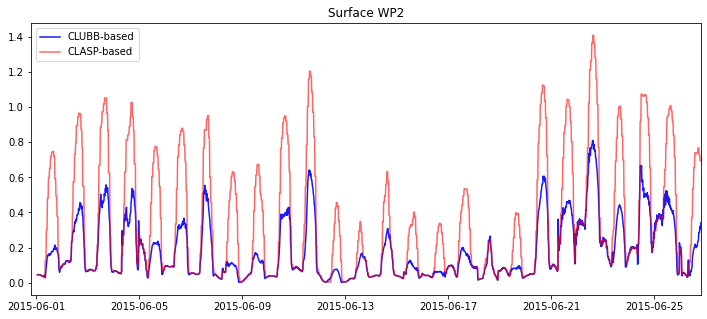

In [66]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')

ax1.plot(times_local,np.squeeze(clubbDS.WP2_CLUBB.values)[:,-1],'b',label='CLUBB-based',alpha=0.9)
ax1.plot(times_local,np.squeeze(claspDS.WP2_CLUBB.values)[:,-1],'r',label='CLASP-based',alpha=0.6)
ax1.legend()
ax1.set_title('Surface WP2')
ax1.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,27))



In [19]:
# Mean diurnal PBLH cycle?
meanDiurnal_clubb = clubbDS.groupby("time.hour").mean()
meanDiurnal_clasp = claspDS.groupby("time.hour").mean()


Text(0, 0.5, 'PBLH [m]')

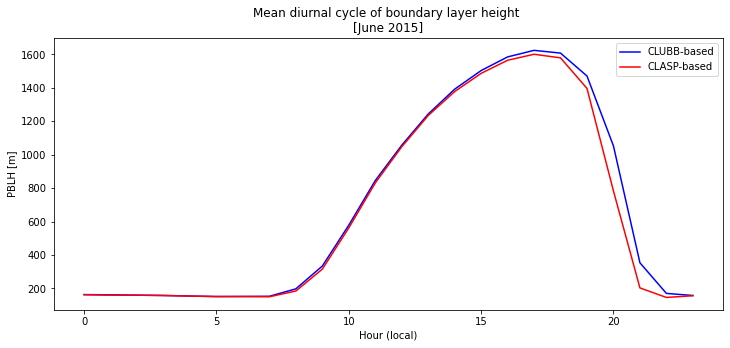

In [21]:
# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 5a UTC, so 5 hour offset 
clubb_diurnalPBL_double = np.full([48], np.nan)
clubb_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_clubb.PBLH.values)
clubb_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_clubb.PBLH.values)

clasp_diurnalPBL_double = np.full([48], np.nan)
clasp_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_clasp.PBLH.values)
clasp_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_clasp.PBLH.values)

hoursDouble = np.full([48],np.nan)
hoursDouble[0:24] = meanDiurnal_clubb.hour.values
hoursDouble[24::] = meanDiurnal_clubb.hour.values+24

fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')

ax1.plot(meanDiurnal_clubb.hour.values,clubb_diurnalPBL_double[5:29],'b',label='CLUBB-based')
ax1.plot(meanDiurnal_clubb.hour.values,clasp_diurnalPBL_double[5:29],'r',label='CLASP-based')
ax1.legend()
ax1.set_title('Mean diurnal cycle of boundary layer height \n[June 2015]')
ax1.set_xlabel('Hour (local)')
ax1.set_ylabel('PBLH [m]')
#ax1.set_ylim([-0.1e-6, 1.3e-6])


(16587.0, 16613.0)

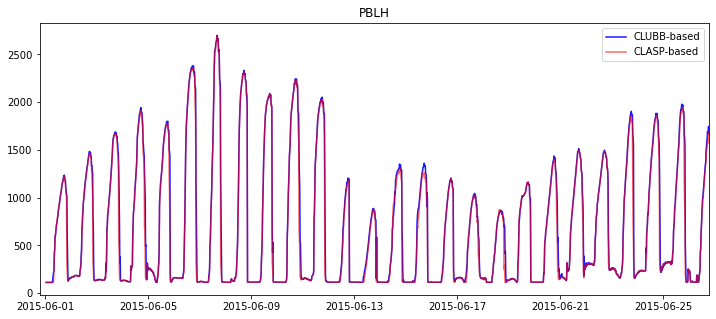

In [22]:
fig, ax1 = plt.subplots(1,1, figsize=(12, 5), 
                     facecolor='w', edgecolor='k')

ax1.plot(times_local,np.squeeze(clubbDS.PBLH.values)[:],'b',label='CLUBB-based',alpha=0.9)
ax1.plot(times_local,np.squeeze(claspDS.PBLH.values)[:],'r',label='CLASP-based',alpha=0.6)
ax1.legend()
ax1.set_title('PBLH')
ax1.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,27))


Text(0.5, 1.0, '8-10a Mean \nTemperature Variance')

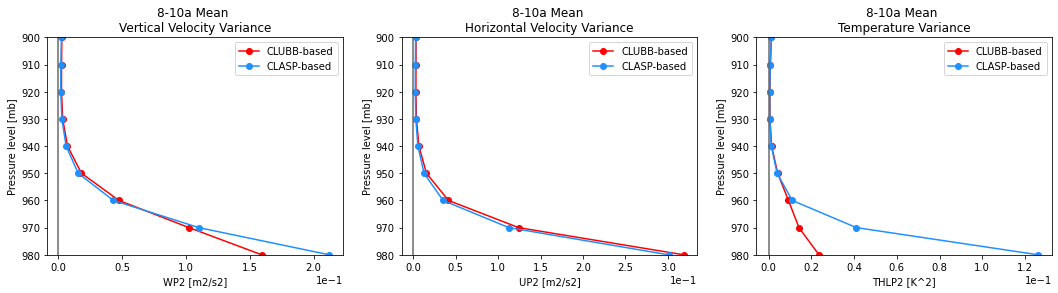

In [70]:
# Plot mean vertical profiles in morning? (8-10a local)
iMorning     = np.where((times_local.hour>=8) & (times_local.hour<10))[0]
#iMorning     = np.where((times_local.hour>=14) & (times_local.hour<17))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 4),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


axs[0].plot(np.nanmean(np.squeeze(WP2_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[0].plot(np.nanmean(np.squeeze(WP2_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('WP2 [m2/s2]')
axs[0].set_title('8-10a Mean \nVertical Velocity Variance')


axs[1].plot(np.nanmean(np.squeeze(UP2_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[1].plot(np.nanmean(np.squeeze(UP2_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('UP2 [m2/s2]')
axs[1].set_title('8-10a Mean \nHorizontal Velocity Variance')

axs[2].plot(np.nanmean(np.squeeze(THLP2_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[2].plot(np.nanmean(np.squeeze(THLP2_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('THLP2 [K^2]')
axs[2].set_title('8-10a Mean \nTemperature Variance')

# axs[3].plot(np.nanmean(np.squeeze(RTP2_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
# axs[3].plot(np.nanmean(np.squeeze(RTP2_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
# axs[3].axvline(0,color='dimgrey')
# axs[3].set_ylim([900,980])
# axs[3].invert_yaxis()
# axs[3].legend()
# #axs[0].set_xlim([-15e-5,15e-5])
# axs[3].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
# axs[3].set_ylabel('Pressure level [mb]')
# axs[3].set_xlabel('RTP2 [g^2/kg^2]')
# axs[3].set_title('8-10a Mean \nMoisture Variance')



Text(0.5, 1.0, '8-10a Mean \nVertical Velocity Skew')

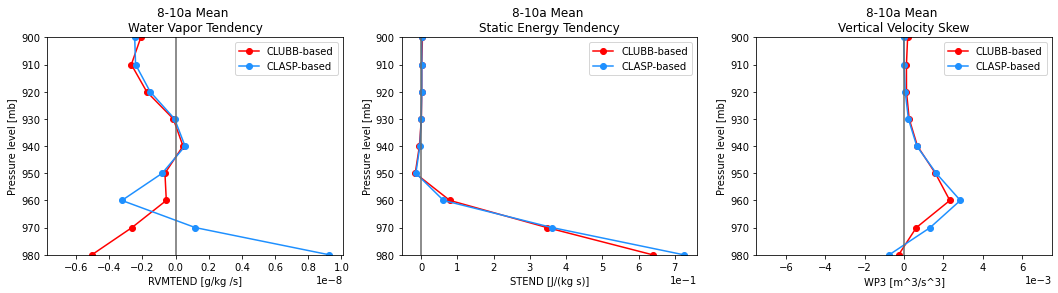

In [71]:
# Plot mean vertical profiles in morning? (8-10a local)
iMorning     = np.where((times_local.hour>=8) & (times_local.hour<10))[0]
#iMorning     = np.where((times_local.hour>=14) & (times_local.hour<17))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 4),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


axs[0].plot(np.nanmean(np.squeeze(RVMTEND_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[0].plot(np.nanmean(np.squeeze(RVMTEND_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('RVMTEND [g/kg /s]')
axs[0].set_title('8-10a Mean \nWater Vapor Tendency')


axs[1].plot(np.nanmean(np.squeeze(STEND_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[1].plot(np.nanmean(np.squeeze(STEND_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('STEND [J/(kg s)]')
axs[1].set_title('8-10a Mean \nStatic Energy Tendency')

axs[2].plot(np.nanmean(np.squeeze(WP3_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[2].plot(np.nanmean(np.squeeze(WP3_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
axs[2].set_xlim([-0.75e-2,0.75e-2])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('WP3 [m^3/s^3]')
axs[2].set_title('8-10a Mean \nVertical Velocity Skew')

# axs[3].plot(np.nanmean(np.squeeze(RTP2_clubb)[iMorning,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
# axs[3].plot(np.nanmean(np.squeeze(RTP2_clasp)[iMorning,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
# axs[3].axvline(0,color='dimgrey')
# axs[3].set_ylim([900,980])
# axs[3].invert_yaxis()
# axs[3].legend()
# #axs[0].set_xlim([-15e-5,15e-5])
# axs[3].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
# axs[3].set_ylabel('Pressure level [mb]')
# axs[3].set_xlabel('RTP2 [g^2/kg^2]')
# axs[3].set_title('8-10a Mean \nMoisture Variance')




Text(0.5, 1.0, '2-5p Mean \nTemperature Variance')

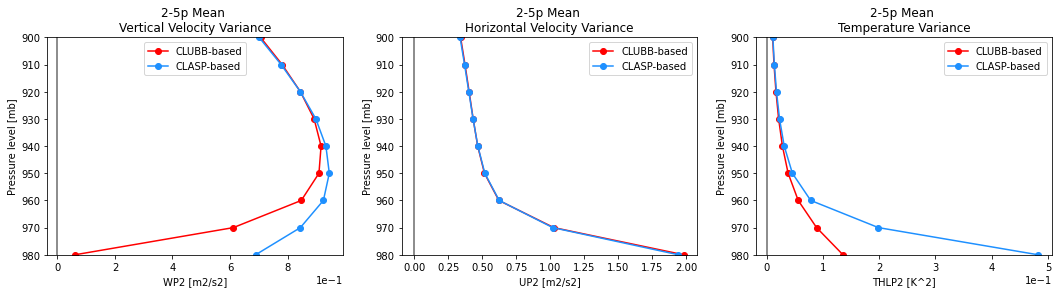

In [72]:
# Plot mean vertical profiles in afternoon? (2-5p local)
iAfternoon  = np.where((times_local.hour>=14) & (times_local.hour<17))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 4),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


axs[0].plot(np.nanmean(np.squeeze(WP2_clubb)[iAfternoon,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[0].plot(np.nanmean(np.squeeze(WP2_clasp)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('WP2 [m2/s2]')
axs[0].set_title('2-5p Mean \nVertical Velocity Variance')


axs[1].plot(np.nanmean(np.squeeze(UP2_clubb)[iAfternoon,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[1].plot(np.nanmean(np.squeeze(UP2_clasp)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('UP2 [m2/s2]')
axs[1].set_title('2-5p Mean \nHorizontal Velocity Variance')

axs[2].plot(np.nanmean(np.squeeze(THLP2_clubb)[iAfternoon,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[2].plot(np.nanmean(np.squeeze(THLP2_clasp)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('THLP2 [K^2]')
axs[2].set_title('2-5p Mean \nTemperature Variance')


Text(0.5, 1.0, '2-5p Mean \nVertical Velocity Skew')

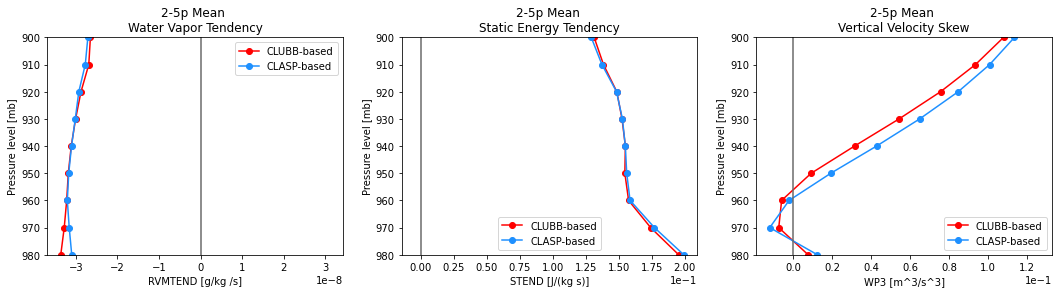

In [73]:
# Plot mean vertical profiles in afternoon? (2-5p local)
iAfternoon  = np.where((times_local.hour>=14) & (times_local.hour<17))[0]

fig, axs_all = plt.subplots(1,3, figsize=(18, 4),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.1)


axs[0].plot(np.nanmean(np.squeeze(RVMTEND_clubb)[iAfternoon,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[0].plot(np.nanmean(np.squeeze(RVMTEND_clasp)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[0].axvline(0,color='dimgrey')
axs[0].set_ylim([900,980])
axs[0].invert_yaxis()
axs[0].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[0].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[0].set_ylabel('Pressure level [mb]')
axs[0].set_xlabel('RVMTEND [g/kg /s]')
axs[0].set_title('2-5p Mean \nWater Vapor Tendency')


axs[1].plot(np.nanmean(np.squeeze(STEND_clubb)[iAfternoon,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[1].plot(np.nanmean(np.squeeze(STEND_clasp)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[1].axvline(0,color='dimgrey')
axs[1].set_ylim([900,980])
axs[1].invert_yaxis()
axs[1].legend()
#axs[0].set_xlim([-15e-5,15e-5])
axs[1].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[1].set_ylabel('Pressure level [mb]')
axs[1].set_xlabel('STEND [J/(kg s)]')
axs[1].set_title('2-5p Mean \nStatic Energy Tendency')

axs[2].plot(np.nanmean(np.squeeze(WP3_clubb)[iAfternoon,:], axis=0), pnew64,'o-',color='r',label='CLUBB-based')
axs[2].plot(np.nanmean(np.squeeze(WP3_clasp)[iAfternoon,:], axis=0), pnew64,'o-',color='dodgerblue',label='CLASP-based')
axs[2].axvline(0,color='dimgrey')
axs[2].set_ylim([900,980])
axs[2].invert_yaxis()
axs[2].legend()
#axs[2].set_xlim([-0.75e-2,0.75e-2])
axs[2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))
axs[2].set_ylabel('Pressure level [mb]')
axs[2].set_xlabel('WP3 [m^3/s^3]')
axs[2].set_title('2-5p Mean \nVertical Velocity Skew')



Text(0, 0.5, '[m/s]')

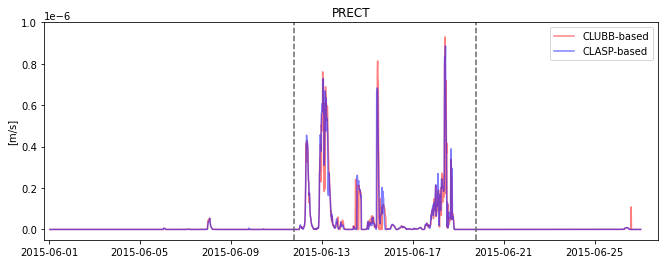

In [55]:
fig, ax1 = plt.subplots(1,1, figsize=(11, 4),
                     facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace=0.3)

# Plot 32 levels:
# ---------------
ax1.plot(times_local, np.squeeze(clubbDS.PRECT.values)[:],'r', label='CLUBB-based',alpha=0.5)
ax1.plot(times_local, np.squeeze(claspDS.PRECT.values)[:],'b', label='CLASP-based',alpha=0.5)
#ax1.plot(timesNate_local, np.squeeze(nateHMG.prec_srf.values/3600.0/1000.0)[:], color='k', label='Obs')  # Original units = mm/hr
ax1.legend()
ax1.set_title('PRECT')
ax1.set_xlim(datetime.date(2015,6,1),datetime.date(2015,6,28))
#ax1.set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
ax1.set_ylim([-0.05e-6, 1e-6])
ax1.axvline(datetime.datetime(2015,6,20),color='dimgray',linestyle='--')
ax1.axvline(datetime.datetime(2015,6,12),color='dimgray',linestyle='--')
ax1.set_ylabel('[m/s]')



Text(0, 0.5, '[m/s]')

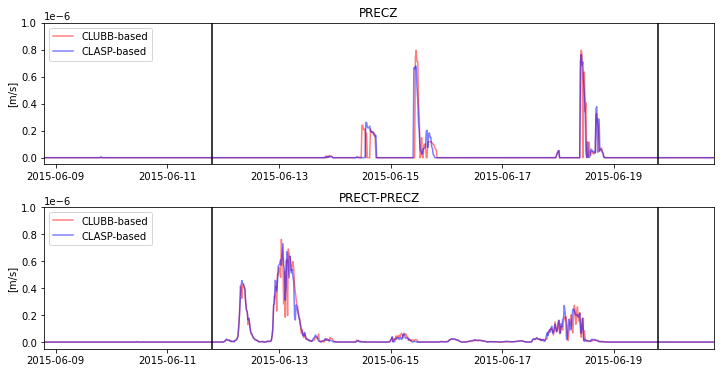

In [56]:
fig, axs_all = plt.subplots(2,1, figsize=(12, 6),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.3)

# Plot PRECZ:
# ---------------
axs[0].plot(times_local, np.squeeze(clubbDS.PRECZ.values)[:],'r', label='CLUBB-based',alpha=0.5)
axs[0].plot(times_local, np.squeeze(claspDS.PRECZ.values)[:],'b', label='CLASP-based',alpha=0.5)
axs[0].legend()
axs[0].set_title('PRECZ')
axs[0].set_xlim(datetime.date(2015,6,9),datetime.date(2015,6,21))
#axs[0].set_xlim(datetime.date(2015,6,8),datetime.date(2015,6,27))
axs[0].set_ylim([-0.05e-6, 1e-6])
axs[0].axvline(datetime.datetime(2015,6,20),color='k')
axs[0].axvline(datetime.datetime(2015,6,12),color='k')
axs[0].set_ylabel('[m/s]')

# Plot PRECT-PRECZ:
# ---------------
axs[1].plot(times_local, np.squeeze(clubbDS.PRECT.values-clubbDS.PRECZ.values)[:],'r', label='CLUBB-based',alpha=0.5)
axs[1].plot(times_local, np.squeeze(claspDS.PRECT.values-claspDS.PRECZ.values)[:],'b', label='CLASP-based',alpha=0.5)
axs[1].legend()
axs[1].set_title('PRECT-PRECZ')
axs[1].set_xlim(datetime.date(2015,6,9),datetime.date(2015,6,21))
axs[1].axvline(datetime.datetime(2015,6,20),color='k')
axs[1].axvline(datetime.datetime(2015,6,12),color='k')
#axs[1].set_xlim(datetime.date(2015,6,11),datetime.date(2015,6,20))
axs[1].set_ylim([-0.05e-6, 1e-6])
axs[1].set_ylabel('[m/s]')




In [57]:
# Define three different periods... 
iEarlyDry = np.where(times_local.day<=11)[0]
iWet      = np.where( (times_local.day>=12) & (times_local.day<=19) )[0]
iLateDry  = np.where(times_local.day>=20)[0]

# Define early dry periods... 
clubb_earlyDry = clubbDS.isel(time=iEarlyDry)
clasp_earlyDry = claspDS.isel(time=iEarlyDry)

# Define wet period...
clubb_wet = clubbDS.isel(time=iWet)
clasp_wet = claspDS.isel(time=iWet)

# Define late dry periods...
clubb_lateDry = clubbDS.isel(time=iLateDry)
clasp_lateDry = claspDS.isel(time=iLateDry)


**What does average PBLH look like in these periods?**

In [58]:
# -------------------------------- 
#   Early dry period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_earlyDry_clubb = clubb_earlyDry.groupby("time.hour").mean()
meanDiurnal_earlyDry_clasp = clasp_earlyDry.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
clubb_diurnalPBL_double       = np.full([48], np.nan)
clubb_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_earlyDry_clubb.PBLH.values)
clubb_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_earlyDry_clubb.PBLH.values)
clubb_diurnalPBLH_earlyDry    = clubb_diurnalPBL_double[6:30]

clasp_diurnalPBL_double       = np.full([48], np.nan)
clasp_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_earlyDry_clasp.PBLH.values)
clasp_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_earlyDry_clasp.PBLH.values)
clasp_diurnalPBLH_earlyDry    = clasp_diurnalPBL_double[6:30]


In [59]:
# -------------------------------- 
#   Wet period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_wet_clubb = clubb_wet.groupby("time.hour").mean()
meanDiurnal_wet_clasp = clasp_wet.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
clubb_diurnalPBL_double       = np.full([48], np.nan)
clubb_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_wet_clubb.PBLH.values)
clubb_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_wet_clubb.PBLH.values)
clubb_diurnalPBLH_wet         = clubb_diurnalPBL_double[6:30]

clasp_diurnalPBL_double       = np.full([48], np.nan)
clasp_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_wet_clasp.PBLH.values)
clasp_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_wet_clasp.PBLH.values)
clasp_diurnalPBLH_wet         = clasp_diurnalPBL_double[6:30]


In [60]:
# -------------------------------- 
#   Late dry period 
# -------------------------------- 

# Mean diurnal cycle (in UTC time, though)
meanDiurnal_lateDry_clubb = clubb_lateDry.groupby("time.hour").mean()
meanDiurnal_lateDry_clasp = clasp_lateDry.groupby("time.hour").mean()

# Easier to plot in local time, so let's double up on the diurnal cycle,
#  Then plot the correct section representing 12a-12a
# 
# CDT to UTC: 12a CDT = 6a UTC, so 6 hour offset 
clubb_diurnalPBL_double       = np.full([48], np.nan)
clubb_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_lateDry_clubb.PBLH.values)
clubb_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_lateDry_clubb.PBLH.values)
clubb_diurnalPBLH_lateDry     = clubb_diurnalPBL_double[6:30]

clasp_diurnalPBL_double       = np.full([48], np.nan)
clasp_diurnalPBL_double[0:24] = np.squeeze(meanDiurnal_lateDry_clasp.PBLH.values)
clasp_diurnalPBL_double[24::] = np.squeeze(meanDiurnal_lateDry_clasp.PBLH.values)
clasp_diurnalPBLH_lateDry     = clasp_diurnalPBL_double[6:30]



Text(0.5, 1.0, 'Late Dry Period')

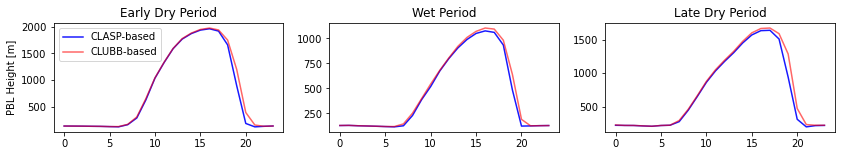

In [68]:
# What is the differenct in PBLH within each of these? 
fig, axs_all = plt.subplots(1,3, figsize=(14, 2),
                     facecolor='w', edgecolor='k')
axs = axs_all.ravel()
fig.subplots_adjust(hspace=0.35)


axs[0].plot(meanDiurnal_lateDry_clubb.hour.values,clasp_diurnalPBLH_earlyDry,'b',label='CLASP-based',alpha=0.9)
axs[0].plot(meanDiurnal_lateDry_clubb.hour.values,clubb_diurnalPBLH_earlyDry,'r',label='CLUBB-based',alpha=0.6)
axs[0].set_title('Early Dry Period')
axs[0].legend(loc='upper left')
axs[0].set_ylabel('PBL Height [m]')

axs[1].plot(meanDiurnal_lateDry_clubb.hour.values,clasp_diurnalPBLH_wet,'b',label='CLASP-based',alpha=0.9)
axs[1].plot(meanDiurnal_lateDry_clubb.hour.values,clubb_diurnalPBLH_wet,'r',label='CLUBB-based',alpha=0.6)
axs[1].set_title('Wet Period')

axs[2].plot(meanDiurnal_lateDry_clubb.hour.values,clasp_diurnalPBLH_lateDry,'b',label='CLASP-based',alpha=0.9)
axs[2].plot(meanDiurnal_lateDry_clubb.hour.values,clubb_diurnalPBLH_lateDry,'r',label='CLUBB-based',alpha=0.6)
axs[2].set_title('Late Dry Period')